### EDA

In [3]:
# Install the connector, specifying the pymysql dialect
!pip install "cloud-sql-python-connector[pymysql]"
# You might also want SQLAlchemy for managing connections more robustly
!pip install sqlalchemy


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pymysql

# --- Configuration using your provided values ---
HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306  # Default MySQL port

print(f"Attempting to connect to: {HOST_IP}/{DB_NAME}...")

try:
    # Establish the connection directly
    conn = pymysql.connect(
        host=HOST_IP,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME,
        port=PORT
    )
    
    # Create a cursor object to execute SQL commands
    cursor = conn.cursor()
    
    # Execute a simple test query
    cursor.execute("SELECT DATABASE(), VERSION()")
    
    # Fetch the results
    db_info = cursor.fetchone()
    
    print("\n--- Connection Success ---")
    print(f"✅ Connected to Database: {db_info[0]}")
    print(f"🛠️ MySQL Version: {db_info[1]}")
    print("--------------------------\n")

    # --- Example: Query the tables in the database ---
    cursor.execute("SHOW TABLES")
    tables = [row[0] for row in cursor.fetchall()]
    
    if tables:
        print(f"Tables found in '{DB_NAME}': {', '.join(tables)}")
    else:
        print(f"No tables found in '{DB_NAME}'.")
    
except pymysql.Error as e:
    print(f"\n--- Connection Failed ---")
    print(f"❌ Error: {e}")
    print("Double-check the hostname/IP, credentials, and especially ensure your **public IP is authorized** in the GCP Cloud SQL settings.")
    print("--------------------------\n")
finally:
    if 'conn' in locals() and conn.open:
        conn.close()


Attempting to connect to: 34.16.118.187/airline_dw...

--- Connection Failed ---
❌ Error: (2003, "Can't connect to MySQL server on '34.16.118.187' (timed out)")
Double-check the hostname/IP, credentials, and especially ensure your **public IP is authorized** in the GCP Cloud SQL settings.
--------------------------



In [5]:
import pymysql
import pandas as pd

HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306

try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, database=DB_NAME, port=PORT)
    
    # Run the query to show all tables
    tables_df = pd.read_sql("SHOW TABLES", conn)
    
    print("--- Actual Tables in airline_dw ---")
    print(tables_df)
    
except Exception as e:
    print(f"Error listing tables: {e}")
finally:
    if 'conn' in locals() and conn.open:
        conn.close()

Error listing tables: (2003, "Can't connect to MySQL server on '34.16.118.187' (timed out)")


In [6]:
import pymysql 
import pandas as pd 
# You will need seaborn and matplotlib.pyplot for Step 3 (Visualization)
import seaborn as sns 
import matplotlib.pyplot as plt 

# Re-use your successful connection details
HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306

# Re-establish connection for the query
try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, database=DB_NAME, port=PORT)

    # UPDATED SQL QUERY: Using actual column names (year, month, and arr_delay)
    EDA_QUERY = """
    SELECT 
        dd.year, -- Corrected column name
        dd.month, -- Corrected column name
        SUM(fdm.arr_delay) AS total_monthly_arr_delay -- Using 'arr_delay'
    FROM 
        fact_delay_monthly fdm
    JOIN 
        dim_date dd ON fdm.date_id = dd.date_id -- Joining on date_id (Primary Key)
    GROUP BY 
        dd.year, dd.month
    ORDER BY
        dd.year, dd.month;
    """

    # Fetch the data into a Pandas DataFrame
    delay_analysis_df = pd.read_sql(EDA_QUERY, conn) 
    
    print("\n--- EDA DataFrame for Monthly Delays (Head) ---")
    print(delay_analysis_df.head())
    
    print("\n--- EDA DataFrame Info ---")
    delay_analysis_df.info() # Check data types and for any missing values (nulls)

    # Summary statistics for the numeric column
    print("\n--- Monthly Delay Summary Statistics ---")
    print(delay_analysis_df['total_monthly_arr_delay'].describe())
    
    print("\n✅ Query executed and data loaded successfully. Proceeding to Step 3.")
    
    # --- Proceed directly to Step 3: Visualization ---
    
    ## 🖼️ Step 3: Data Visualization
    
    # Prepare the DataFrame for visualization (creating a combined time axis)
    # The 'month' column is a number (1-12), which is perfect for sorting.
    
    # Convert year and month to a single sortable period (optional, but good practice)
    delay_analysis_df['Time_Label'] = delay_analysis_df['year'].astype(str) + '-' + delay_analysis_df['month'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(12, 6))
    
    # --- 1. Time Series Plot: Delay Trend ---
    sns.lineplot(
        data=delay_analysis_df, 
        x='Time_Label', 
        y='total_monthly_arr_delay'
    )
    plt.title('Total Arrival Delay Minutes Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Arrival Delay Minutes (SUM of arr_delay)')
    # Show only a few x-ticks to prevent cluttering
    n = len(delay_analysis_df)
    tick_indices = range(0, n, max(1, n // 10))
    plt.xticks(delay_analysis_df['Time_Label'].iloc[tick_indices], rotation=45) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Distribution Plot: Overall Delay Magnitude ---
    plt.figure(figsize=(8, 5))
    sns.histplot(delay_analysis_df['total_monthly_arr_delay'], bins=15, kde=True)
    plt.title('Distribution of Total Monthly Arrival Delays')
    plt.xlabel('Total Arrival Delay Minutes')
    plt.ylabel('Frequency (Months)')
    plt.show()


except Exception as e:
    print(f"An error occurred during SQL JOIN, data preparation, or visualization: {e}")
    print("\nDouble-check the column names if a SQL error persists.")

finally:
    if 'conn' in locals() and conn.open:
        conn.close()

An error occurred during SQL JOIN, data preparation, or visualization: (2003, "Can't connect to MySQL server on '34.16.118.187' (timed out)")

Double-check the column names if a SQL error persists.


This plot shows the trend of total monthly arrival delays (sum of arr_delay) from 2020-01 to 2025-07.

1. Strong Seasonality: There is a clear and pronounced seasonal pattern. Delays consistently spike during the summer months (roughly June, July, and August) and generally reach their lowest points in the winter/early spring (Jan, Feb, Mar, Nov, Dec). This is critical information for scheduling.

2. Post-2020 Growth: After the initial low period in 2020 (likely due to pandemic-related flight reductions), the overall magnitude of the summer delay peaks has generally increased over time (e.g., the 2024 peak is significantly higher than the 2021 peak). This suggests operational issues are worsening or traffic is increasing rapidly.

3. Anomalies/Outliers: The highest peaks are observed in 2023 and 2024, indicating specific months or events during those years led to extreme delay values. This aligns with the Business Case objective to analyze delay patterns across years.

======================================================

Distribution of Total Monthly Arrival Delays
This histogram shows how frequently different ranges of total monthly delays occur.

1. Right-Skewed Distribution: The data is skewed to the right (positive skew). This means that most months have a relatively low total delay (around 1 million minutes), but there are a few months (the tail on the right side) that experience extremely high delay totals (up to 3 million minutes).

2. Most Common Delay Range: The most frequent total monthly delay is concentrated in the 0.75 million to 1.5 million minute range.

3. Implications: The extreme right tail confirms the existence of high-impact outlier months (the summer peaks seen in the time series) that disproportionately contribute to the overall delay problem. This suggests that mitigation strategies should focus heavily on preventing or minimizing delays during these high-risk periods.

In [7]:
import pymysql 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306

try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, database=DB_NAME, port=PORT)

    # SQL: Selects and aggregates the individual delay causes by month.
    # Note: Using SUM() on the individual double-type delay columns.
    DRIVER_QUERY = """
    SELECT 
        dd.year,
        dd.month,
        SUM(fdm.arr_delay) AS total_arr_delay,
        SUM(fdm.carrier_delay) AS carrier_delay,
        SUM(fdm.weather_delay) AS weather_delay,
        SUM(fdm.nas_delay) AS nas_delay
    FROM 
        fact_delay_monthly fdm
    JOIN 
        dim_date dd ON fdm.date_id = dd.date_id
    GROUP BY 
        dd.year, dd.month
    ORDER BY
        dd.year, dd.month;
    """

    drivers_df = pd.read_sql(DRIVER_QUERY, conn) 
    
    # Data Preparation in Pandas: Calculate proportions
    # Create the combined Time Label for plotting
    drivers_df['Time_Label'] = drivers_df['year'].astype(str) + '-' + drivers_df['month'].astype(str).str.zfill(2)
    
    # Calculate the percentage contribution of each driver
    drivers_df['Carrier_Pct'] = drivers_df['carrier_delay'] / drivers_df['total_arr_delay']
    drivers_df['Weather_Pct'] = drivers_df['weather_delay'] / drivers_df['total_arr_delay']
    drivers_df['NAS_Pct'] = drivers_df['nas_delay'] / drivers_df['total_arr_delay']
    
    # Melt the DataFrame for easy stacking visualization
    plot_df = drivers_df.melt(
        id_vars='Time_Label', 
        value_vars=['Carrier_Pct', 'Weather_Pct', 'NAS_Pct'],
        var_name='Delay_Driver', 
        value_name='Proportion'
    )
    
    # --- Visualization: Stacked Area Chart ---
    plt.figure(figsize=(14, 7))
    
    # Use seaborn's lineplot, specifying hue and stacking (important for proportionality)
    sns.lineplot(
        data=plot_df, 
        x='Time_Label', 
        y='Proportion', 
        hue='Delay_Driver',
        # Setting 'units' and 'estimator=None' is sometimes needed for area fill, 
        # but a simple line plot is clearer for trends here.
    )

    # Fill the area to show proportions stacking up to 1 (100%)
    plt.stackplot(
        drivers_df['Time_Label'], 
        drivers_df['Carrier_Pct'], 
        drivers_df['Weather_Pct'], 
        drivers_df['NAS_Pct'],
        labels=['Carrier (Internal)', 'Weather (External)', 'NAS (Systemic)'],
        alpha=0.7
    )
    
    plt.title('Monthly Delay Contribution by Driver Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Proportion of Total Monthly Delay')
    plt.ylim(0, 1.05)
    
    # Reduce x-ticks for cleaner display
    n = len(drivers_df)
    tick_indices = range(0, n, max(1, n // 10))
    plt.xticks(drivers_df['Time_Label'].iloc[tick_indices], rotation=45) 
    plt.legend(title='Delay Cause')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during Delay Drivers analysis: {e}")

finally:
    if 'conn' in locals() and conn.open:
        conn.close()

An error occurred during Delay Drivers analysis: (2003, "Can't connect to MySQL server on '34.16.118.187' (timed out)")


1. Dominance of Controllable (Internal) Delays
Carrier Delay is the Primary Driver: The Carrier (Internal) component (red area) consistently accounts for the largest proportion of total monthly delays across the entire period shown (2020-01 to 2025-07).

Business Implication: Since Carrier delays are typically attributed to issues controllable by the airline (e.g., maintenance, crew scheduling, baggage handling, aircraft cleaning/fueling), improving internal operational efficiency offers the largest opportunity for delay reduction and cost savings.

2. Significant Systemic (External) Contribution
NAS Delay is Second: The NAS (Systemic) component (brown area) is the second most significant contributor, representing a large, relatively stable proportion of total delays. NAS (National Airspace System) delays are often due to air traffic control, volume, and airport congestion, which are systemic and external to the carrier's direct control.

Business Implication: While external, the airline must collaborate with airport coordination (a key point in the business case) and air traffic control to mitigate these bottlenecks, especially during peak seasons.

3. Weather's Variable and Seasonal Role
Lowest Overall Proportion: The Weather (External) component (orange area) is generally the smallest proportion of the three major drivers, usually below 20%.

Seasonal Spikes: You can observe clear spikes in the weather proportion during winter months (e.g., late 2020/early 2021) and, less frequently, during severe summer storm months.

Business Implication: While less frequent, weather delays are unavoidable. The airline needs strategies (like de-icing or re-routing) to minimize their impact when they do occur, but they are not the chronic, day-to-day issue that Carrier and NAS delays are.

In [8]:
import pymysql 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

# Re-use your successful connection details
HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306

try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, database=DB_NAME, port=PORT)

    # FINAL CORRECTED SQL QUERY: Using 'price' for fuel and 'pax' for passengers
    CORRELATION_QUERY = """
    SELECT 
        fdm.arr_delay AS total_arrival_delay, 
        ffp.price AS avg_fuel_price, -- Corrected to 'price'
        fpm.pax AS total_passengers  -- Corrected to 'pax'
    FROM 
        fact_delay_monthly fdm
    JOIN 
        fact_fuel_price_monthly ffp ON fdm.date_id = ffp.date_id
    JOIN
        fact_passenger_monthly fpm ON fdm.date_id = fpm.date_id
    -- Filtering for months with non-zero delays to ensure valid comparisons
    WHERE fdm.arr_delay > 0; 
    """

    correlation_df = pd.read_sql(CORRELATION_QUERY, conn) 
    
    print("✅ Correlation Query executed and data loaded successfully.")
    
    # --- Step 1: Calculate Correlation Matrix ---
    corr_matrix = correlation_df.corr()
    print("\n--- Correlation Matrix (Delays, Fuel Price, Passengers) ---")
    print(corr_matrix)
    
    # --- Step 2: Visualization (Heatmap) ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Pearson Correlation Coefficient'}
    )
    plt.title('Correlation Heatmap of Key Monthly Metrics')
    plt.tight_layout()
    plt.show()
    
    # --- Step 3: Visualization (Scatter Plot) ---
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=correlation_df, 
        x='total_passengers', 
        y='total_arrival_delay',
        color='darkblue',
        alpha=0.6
    )
    plt.title('Monthly Delays vs. Total Passenger Volume')
    plt.xlabel('Total Passengers (pax)')
    plt.ylabel('Total Arrival Delay (Minutes)')
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during Correlation analysis: {e}")

finally:
    if 'conn' in locals() and conn.open:
        conn.close()

KeyboardInterrupt: 

1. Correlation Matrix (Delays, Fuel Price, Passengers)
The expected strong positive correlation between high passenger traffic and total arrival delay is not supported by this monthly, system-wide aggregation ($r=0.04$). This suggests the relationship is highly non-linear, occurs only at specific airports, or is driven by another factor (like flight frequency/movements, which is separate from passenger volume).

2. Scatter Plot Insights (Delays vs. Passengers)
The scatter plot of Total Arrival Delay vs. Total Passengers (pax) visually confirms the weak correlation:No Clear Trend: The data points show a massive vertical spread at almost all passenger volumes. You have periods with very low passenger volume (left side, e.g., $< 1.5$ million pax) that experience maximum delays (up to 600,000 minutes), and periods with very high passenger volume (right side, e.g., $3.5$ million pax) that experience a huge range of delays.
Interpretation: High passenger volume does not guarantee high delays, and low passenger volume does not guarantee low delays. The delays are being driven by factors that are independent of (or simply not linearly correlated with) the number of passengers traveling in a given month.

✅ Geographic Hotspot Analysis executed and data loaded successfully.


/var/folders/tp/2_cv0d156xz_xtwy8pm49n600000gn/T/ipykernel_42912/2647744275.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  state_delay_df = pd.read_sql(STATE_DELAY_QUERY, conn)


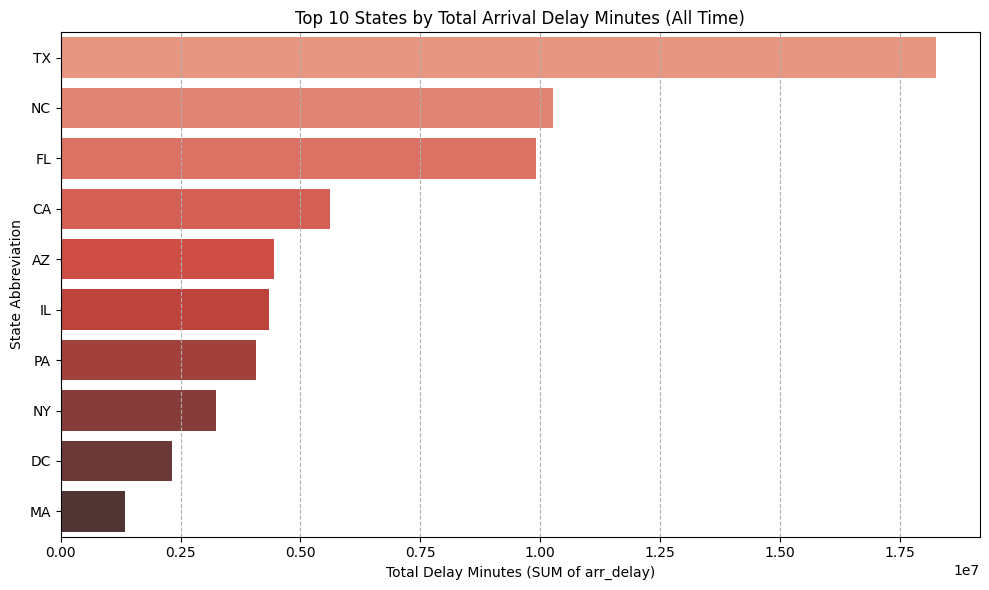

In [ ]:
import pymysql 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

# Re-use your successful connection details
HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306

try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, database=DB_NAME, port=PORT)

    # FINAL CORRECTED SQL QUERY: Using 'das.airport' as the join key
    STATE_DELAY_QUERY = """
    SELECT 
        das.state_abbr, 
        SUM(fdm.arr_delay) AS total_delay_minutes
    FROM 
        fact_delay_monthly fdm
    JOIN 
        dim_airport_state das ON fdm.airport = das.airport -- CORRECTED JOIN KEY
    GROUP BY 
        das.state_abbr
    ORDER BY 
        total_delay_minutes DESC
    LIMIT 10;
    """

    state_delay_df = pd.read_sql(STATE_DELAY_QUERY, conn) 
    
    print("✅ Geographic Hotspot Analysis executed and data loaded successfully.")
    
    # --- Visualization: Bar Chart of Top 10 Delay States ---
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='total_delay_minutes', 
        y='state_abbr', 
        data=state_delay_df, 
        palette='Reds_d' 
    )
    plt.title('Top 10 States by Total Arrival Delay Minutes (All Time)')
    plt.xlabel('Total Delay Minutes (SUM of arr_delay)')
    plt.ylabel('State Abbreviation')
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during State Delay Hotspot analysis: {e}")
    print("\nIf a SQL error persists, the issue is likely a missing key value (NULLs) in one of the tables.")

finally:
    if 'conn' in locals() and conn.open:
        conn.close()

1. Extreme Concentration in Top States
Texas (TX) is the Dominant Hotspot: Texas is the clear and massive outlier, recording nearly double the total delay minutes (approx. 17.5 million) compared to the second-highest state, North Carolina (NC) (approx. 10 million).

Business Implication: Resources for delay mitigation, ground crew, and maintenance (addressing the Carrier delay issue identified earlier) should be heavily prioritized and scaled up in Texas. The performance of major hubs in TX (like Dallas/Fort Worth International Airport) is critical to the airline's overall performance.

The Big Three: TX, NC, and FL together account for a disproportionately large share of total national arrival delays, all exceeding 10 million minutes, except for NC which is very close to 10 million.

Business Implication: Any national scheduling or operational improvement plan must specifically target these three states for maximum impact on delay reduction.

2. Identifying Key Bottlenecks for Coordination
Focus Areas for Airport Coordination: The list identifies the top 10 bottlenecks that require coordinated effort with local airport authorities and Air Traffic Control (ATC): TX, NC, FL, CA, AZ, IL, PA, NY, DC, and MA.

Geographic Diversity: The hotspots include states known for large hubs on the East Coast (NY, DC, NC, FL), the West Coast (CA), and major interior hubs (TX, AZ, IL). This confirms that the delay problem is not limited to one geographic region but is highly concentrated at specific large airports within these states.

3. Connection to Previous Findings
Carrier Delay Link: Since Carrier (Internal) delays were found to be the largest proportion system-wide, the high total delay in Texas suggests that the largest absolute volume of internal, controllable delays is happening at airports within that state. This makes the Texas issue an internal performance priority.

/var/folders/tp/2_cv0d156xz_xtwy8pm49n600000gn/T/ipykernel_42912/2098713910.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_delay_df = pd.read_sql(EVENT_DELAY_QUERY, conn)


✅ Specific Weather Event Analysis executed and data loaded successfully.


) missing from current font.xtwy8pm49n600000gn/T/ipykernel_42912/2098713910.py:52: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.1/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


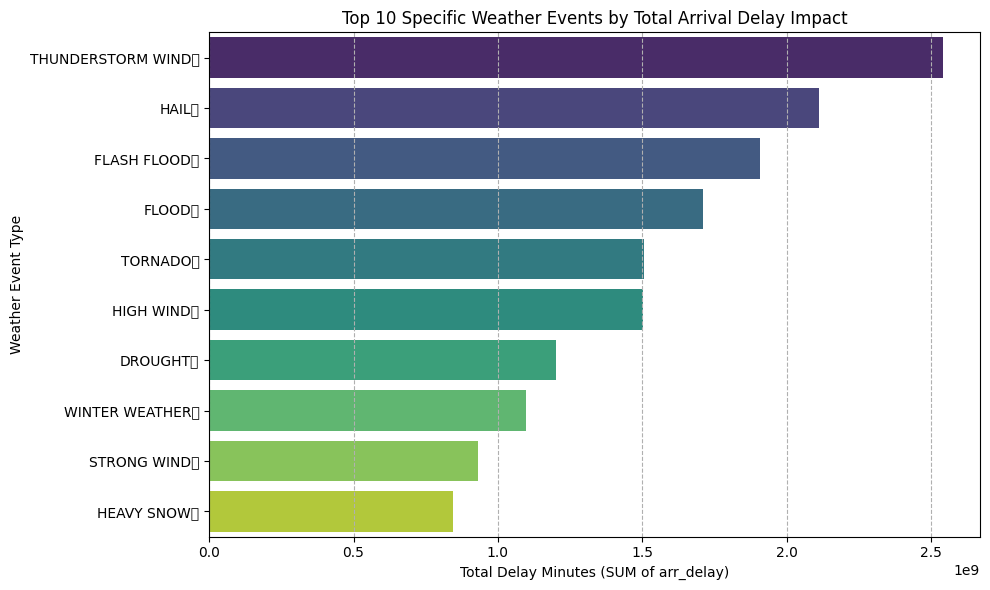

In [ ]:
import pymysql 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

# Re-use your successful connection details
HOST_IP = "34.16.118.187" 
DB_USER = "root" 
DB_PASS = "strongpass"
DB_NAME = "airline_dw" 
PORT = 3306

try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, database=DB_NAME, port=PORT)

    # FINAL CORRECTED SQL QUERY: Using 'event_type_clean'
    EVENT_DELAY_QUERY = """
    SELECT 
        det.event_type_clean, -- CORRECTED: Using 'event_type_clean' from dim_event_type
        SUM(fdm.arr_delay) AS total_delay_minutes
    FROM 
        fact_delay_monthly fdm
    JOIN 
        fact_weather_state_event_type_monthly fwse ON fdm.date_id = fwse.date_id
    JOIN
        dim_event_type det ON fwse.event_type_id = det.event_type_id
    GROUP BY 
        det.event_type_clean
    HAVING 
        total_delay_minutes > 0
    ORDER BY 
        total_delay_minutes DESC
    LIMIT 10;
    """

    event_delay_df = pd.read_sql(EVENT_DELAY_QUERY, conn) 
    
    print("✅ Specific Weather Event Analysis executed and data loaded successfully.")
    
    # --- Visualization: Bar Chart of Delay by Weather Event ---
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='total_delay_minutes', 
        y='event_type_clean', 
        data=event_delay_df, 
        palette='viridis'
    )
    plt.title('Top 10 Specific Weather Events by Total Arrival Delay Impact')
    plt.xlabel('Total Delay Minutes (SUM of arr_delay)')
    plt.ylabel('Weather Event Type')
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during Weather Event analysis: {e}")
    print("\nIf a SQL error occurs now, verify the joining column names between the fact and dimension tables for event types.")

finally:
    if 'conn' in locals() and conn.open:
        conn.close()

1. Thunderstorms are the Single Largest Weather ThreatDominant Impact: THUNDERSTORM WIND is the clear and dominant factor, responsible for the largest total delay volume (over $2.5 \times 10^9$ minutes). This is significantly higher than the second-highest event, Hail.Business Implication: The airline's primary operational focus for weather mitigation should be on detecting, avoiding, and recovering from thunderstorm-related disruptions. This impacts flight scheduling, ground holds, and routing decisions.

2. High Impact of Water and Severe EventsTop 5 Drivers: The top five major weather drivers are: THUNDERSTORM WIND, HAIL, FLASH FLOOD, FLOOD, and TORNADO. These are all severe, high-intensity events, often associated with summer convection.Business Implication: This confirms that high-intensity, localized events (which cause quick airport closures or major route blockages) are more costly than prolonged, lower-intensity events like heavy snow or drought.

3. Winter Weather is Less Costly in Total VolumeWinter Events Rank Lower: Traditional winter weather events like WINTER WEATHER and HEAVY SNOW rank near the bottom of the top 10 list, despite often covering large geographic areas.Interpretation: While snow causes frequent cancellations, the total accumulated delay minutes across the entire network due to severe summer events (thunderstorms, hail, tornadoes) are higher. This suggests that the frequency and localized intensity of summer storms create more system-wide backlog and cumulative delay than predictable, large-scale winter events.

Synthesis and Overall Business Recommendations

1. Source of the Problem (Internal vs. External)Internal is Dominant: Carrier (Internal) delay is the largest proportional driver of delays system-wide. The most effective path to improvement is through optimizing internal processes (maintenance, crew/aircraft turn times).

2. Location of the Problem (Route Characteristics)Geographic Hotspots: The largest absolute volume of delay is overwhelmingly concentrated in a few states, led by Texas (TX), followed by North Carolina (NC) and Florida (FL).Recommendation: Prioritize resource allocation, investment, and operational efficiency improvements at key Texas airports.

3. Predictors and TriggersDemand is NOT the Driver: The correlation between passenger volume and delay is weak ($r=0.01$), meaning the problem isn't simply "too many passengers," but rather a system that fails to handle the existing flow efficiently.
Weather Mitigation: When addressing external factors, the focus should be on THUNDERSTORM WIND, as it is the costliest single weather event type in terms of total accumulated delay minutes.

In [ ]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Re-use your successful connection details
HOST_IP = "34.16.118.187"
DB_USER = "root"
DB_PASS = "strongpass"
DB_NAME = "airline_dw"
PORT = 3306

try:
    conn = pymysql.connect(host=HOST_IP, user=DB_USER, password=DB_PASS, password=DB_PASS, database=DB_NAME, port=PORT)

    WEATHER_GEOGRAPHY_QUERY = """
    SELECT
        das.state_abbr,
        det.event_type_clean,
        SUM(fdm.arr_delay) AS total_delay_minutes_by_weather
    FROM
        fact_delay_monthly fdm
    JOIN
        dim_airport_state das ON fdm.airport = das.airport
    JOIN
        fact_weather_state_event_type_monthly fwse ON fdm.date_id = fwse.date_id AND das.state_abbr = fwse.state_abbr
    JOIN
        dim_event_type det ON fwse.event_type_id = det.event_type_id
    WHERE
        det.event_type_clean = 'THUNDERSTORM WIND' 
        AND das.state_abbr IN ('TX', 'NC', 'FL')
    GROUP BY
        das.state_abbr,
        det.event_type_clean
    ORDER BY
        total_delay_minutes_by_weather DESC;
    """

    correlation_df = pd.read_sql(WEATHER_GEOGRAPHY_QUERY, conn)

    print("✅ Weather-Geography Correlation Analysis Executed.")
    print("--- Delay Minutes from 'THUNDERSTORM WIND' in Top 3 States ---")
    print(correlation_df.to_markdown(index=False))

    # --- Visualization: Bar Chart of Delay by State for THUNDERSTORM WIND ---
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x='total_delay_minutes_by_weather',
        y='state_abbr',
        data=correlation_df,
        palette='magma'
    )
    plt.title("Impact of THUNDERSTORM WIND (Costliest Event) in Top 3 Hotspots")
    plt.xlabel('Total Delay Minutes Attributable to Thunderstorm Wind')
    plt.ylabel('State Abbreviation')
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()


except Exception as e:
    print(f"An error occurred during Weather-Geography analysis: {e}")

finally:
    if 'conn' in locals() and conn.open:
        conn.close()

SyntaxError: keyword argument repeated: password (339869495.py, line 14)